In [135]:
import pandas as pd
import os
current_loc = os.getcwd()
expenses = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'expenses.csv'))
gdp = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'gdp.csv'))
gns = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'goods_and_services.csv'))
index_consumer_services = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'index_consumer_services.csv'))
exchange_rate = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'pound-dollar-exchange-rate-historical-chart.csv'))
unemployment = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'macro_indicators', 'unemployment.csv'))

gdp = gdp.rename(columns={'DATE': 'date'})
gns = gns.iloc[:,:8]
gns['date'] = pd.to_datetime(gns['date'], format='%d/%m/%Y')
gdp['date'] = pd.to_datetime(gns['date'], format='%d/%m/%Y')
expenses['date'] = pd.to_datetime(gns['date'], format='%d/%m/%Y')
unemployment = unemployment.iloc[:128,:]

quarterly_data = expenses.merge(gdp, on='date', how='left').merge(gns, on='date', how='left')
quarterly_data = quarterly_data.drop(['exports', 'exports_goods', 'exports_services', 'imports', 'imports_goods', 'imports_services'],axis=1)
monthly_data = unemployment.merge(index_consumer_services,on='date',how='left')
daily_data = exchange_rate
quarterly_data.head()

,date,expenses,GDP,net_export_goods_and_services
0,2014-01-01,"112,036",17197.738,"-510,088"
1,2014-04-01,"120,636",17518.508,"-505,404"
2,2014-07-01,"119,828",17804.228,"-489,357"
3,2014-10-01,"122,058",17912.079,"-530,751"
4,2015-01-01,"115,066",18063.529,"-526,432"


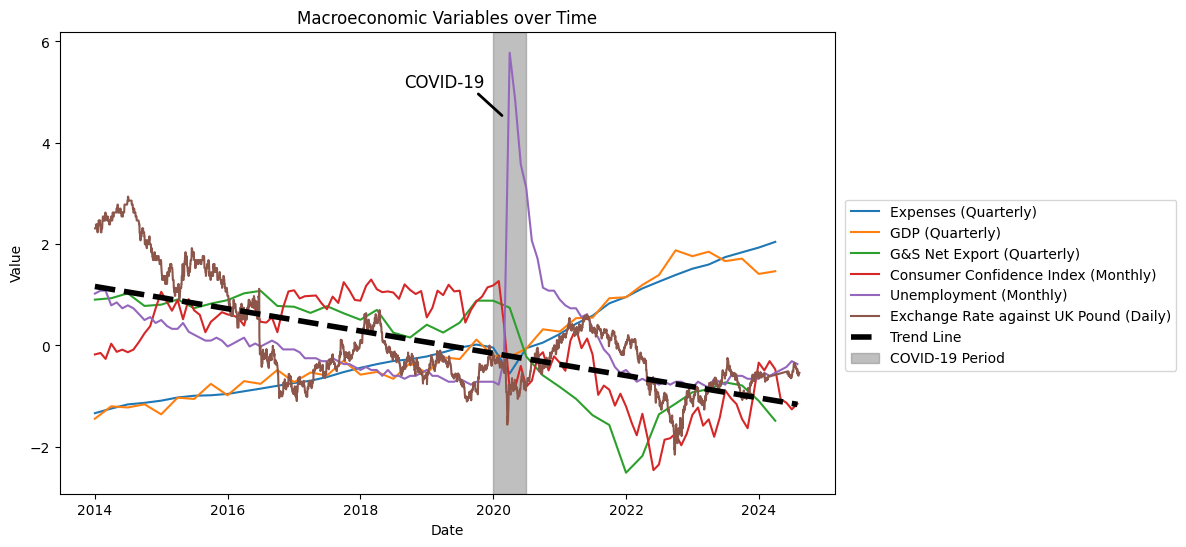

In [144]:
# Plotting
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
covariates_quarterly = quarterly_data.columns.difference(['date'])
covariate_labels_quarterly = ['Expenses (Quarterly)', 'GDP (Quarterly)', 'G&S Net Export (Quarterly)']

def df_standardizer(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.dropna() # removing the dates
    dates = df['date']
    columns_to_standardize = df.columns.difference(['date'])
    for column in df.columns.difference(['date']):
        df.loc[:, column] = pd.to_numeric(df[column].astype(str).str.replace(',', ''), errors='coerce')
        df.loc[:,column] = pd.to_numeric(df[column], errors='coerce')  # Convert back to numeric
        df.loc[:,column] = df[column].astype(float) 
    data_to_standardize = df[columns_to_standardize]
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data_to_standardize)
    standardized_df = pd.DataFrame(standardized_data, columns=columns_to_standardize)
    standardized_df = pd.concat([dates.reset_index(drop=True), standardized_df.reset_index(drop=True)], axis=1)
    return(standardized_df)

covariates_monthly = monthly_data.columns.difference(['date'])
covariate_labels_monthly = ['Consumer Confidence Index (Monthly)', 'Unemployment (Monthly)']
standardized_df_monthly = df_standardizer(monthly_data)

covariates_daily = daily_data.columns.difference(['date'])
covariate_labels_daily = ['Exchange Rate against UK Pound (Daily)']
standardized_df_daily = df_standardizer(daily_data)

standardized_df_quarterly = df_standardizer(quarterly_data)
plt.figure(figsize=(10, 6))
# Plot each covariate as a line on the same graph
for i in range(len(covariates_quarterly)):
    covariate_name = covariates_quarterly[i]
    label = covariate_labels_quarterly[i]
    plt.plot(standardized_df_quarterly['date'], standardized_df_quarterly[covariate_name], label=label)

for i in range(len(covariates_monthly)):
    covariate_name = covariates_monthly[i]
    label = covariate_labels_monthly[i]
    plt.plot(standardized_df_monthly['date'], standardized_df_monthly[covariate_name], label=label)
plt.plot(standardized_df_daily['date'], standardized_df_daily['pound_dollar_exchange_rate'], label=covariate_labels_daily[0])

X = np.arange(len(standardized_df_monthly)).reshape(-1, 1)  # Use index as feature
y = standardized_df_monthly["ics"].values  # The selected covariate

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values for the trend line
trend_line = model.predict(X)

# Plot the trend line
plt.plot(standardized_df_monthly['date'], trend_line, color='black', linestyle='--', linewidth=4, label='Trend Line')

plt.axvspan(pd.to_datetime('2019-12-30'), pd.to_datetime('2020-06-30'), color='gray', alpha=0.5, label='COVID-19 Period')
plt.text(pd.to_datetime('2018-08-30'), 5.1, 'COVID-19', fontsize=12, color='black')
plt.annotate(
    '',  # No label for the arrow itself
    xy=(pd.to_datetime('2020-03-01'), 4.5),  # End point of the arrow (somewhere between the vertical lines)
    xytext=(pd.to_datetime('2019-09-30'), 5),  # Start point of the arrow (position of the text)
    arrowprops=dict(arrowstyle='-', color='black',linewidth=2, linestyle='-')  # Line style and color
)

plt.title('Macroeconomic Variables over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='lower right', bbox_to_anchor=(1.45, 0.25))


Text(0.5, 1.0, 'Macroeconomic Factors Correlation Matrix')

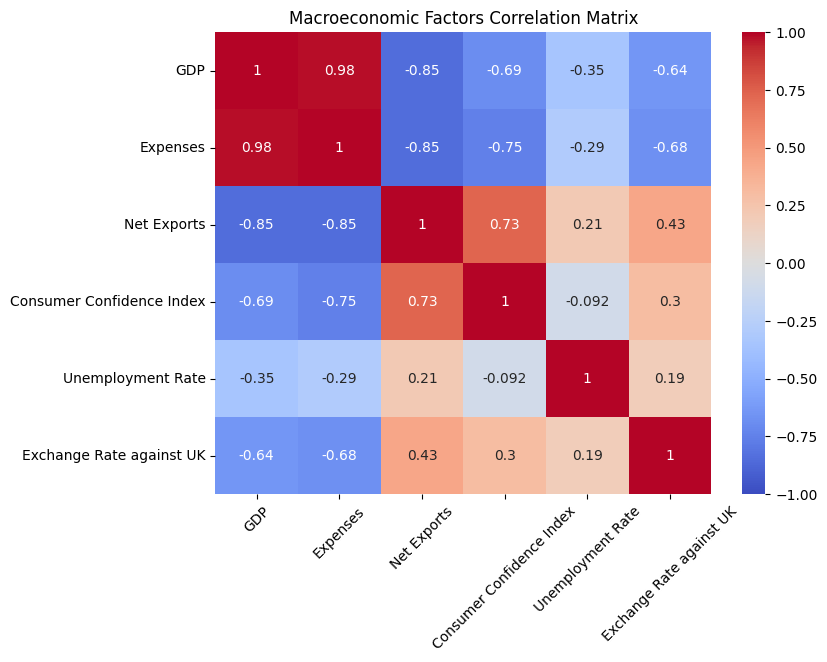

In [150]:
combined_df = pd.merge_asof(standardized_df_quarterly.sort_values('date'), 
                             standardized_df_monthly.sort_values('date'), 
                             on='date', 
                             direction='nearest')
combined_df = pd.merge_asof(combined_df.sort_values('date'), 
                             standardized_df_daily.sort_values('date'), 
                             on='date', 
                             direction='nearest')
# combined_df
col_excl_date = combined_df.drop('date',axis=1)
corr_matrix = col_excl_date.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
heatmap.set_xticklabels(['GDP', 'Expenses', 'Net Exports', 'Consumer Confidence Index', 'Unemployment Rate', "Exchange Rate against UK"], rotation=45)  # x-axis labels
heatmap.set_yticklabels(['GDP', 'Expenses', 'Net Exports', 'Consumer Confidence Index', 'Unemployment Rate', "Exchange Rate against UK"], rotation=0)   # y-axis labels

# Add title
plt.title('Macroeconomic Factors Correlation Matrix')

Text(0.5, 1.0, 'Fundamental Factors Correlation Matrix')

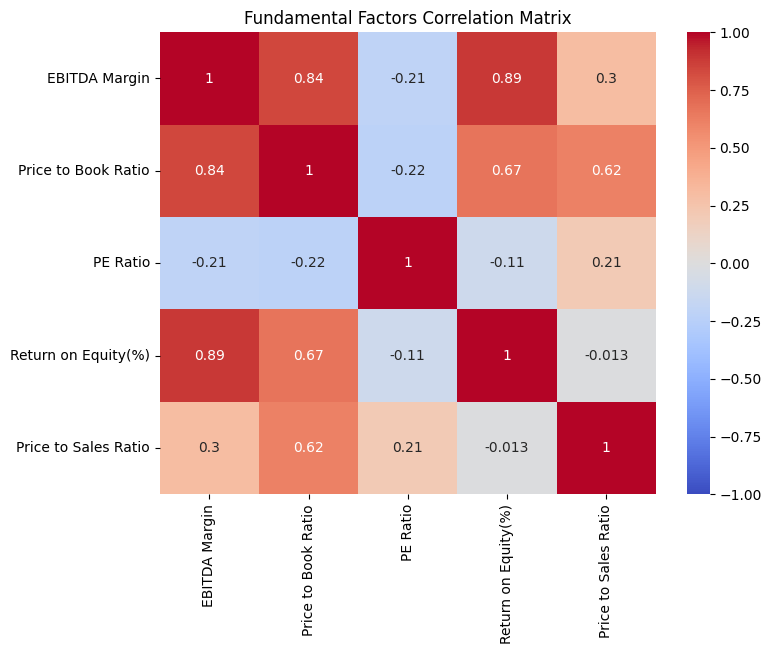

In [218]:
# Visualisation of Fundamental Indicators
dbitda_ratio = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'DBITDA_ratio.csv'))
pb_ratio = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'PB_ratio.csv'))
pe_ratio = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'PE_ratio.csv'))
ps_ratio = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'PS_ratio.csv'))
roe = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'ROE.csv'))

# Merging files by date
dbitda_ratio['Date'] = pd.to_datetime(dbitda_ratio['Date'], format='%d/%m/%Y')
dbitda_ratio = dbitda_ratio.drop(["TTM Revenue(Billion)","TTM EBITDA(Billion)"],axis=1)

pb_ratio['Date'] = pd.to_datetime(pb_ratio['Date'], format='%d/%m/%Y')
pb_ratio = pb_ratio.drop(["Stock Price","Book Value per Share"],axis=1)

pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'], format='%Y-%m-%d')
pe_ratio = pe_ratio.drop(["Stock Price","Net EPS"],axis=1)

ps_ratio['Date'] = pd.to_datetime(ps_ratio['Date'], format='%d/%m/%Y')
ps_ratio = ps_ratio.drop(["Stock Price","TTM Sales per Share"],axis=1)

roe['Date'] = pd.to_datetime(roe['Date'], format='%Y-%m-%d')
roe = roe.drop(["TTM Net Income (Billions)","Shareholder's Equity (Billion)"],axis=1)

dbitda_ratio_filtered = dbitda_ratio[dbitda_ratio['Date'] >= pd.to_datetime('2014-01-01')]
pb_ratio_filtered = pb_ratio[pb_ratio['Date'] >= pd.to_datetime('2014-01-01')]
dbitda_ratio_filtered = dbitda_ratio_filtered.sort_values(by=['Company', 'Date'])
pb_ratio_filtered = pb_ratio_filtered.sort_values(by=['Company', 'Date'])

combined_df = dbitda_ratio_filtered.merge(pb_ratio_filtered, on=['Company','Date'], how='left').merge(pe_ratio, on=['Company','Date'], how='left').merge(roe, on=['Company','Date'], how='left').merge(ps_ratio, on = ['Company','Date'], how='left')
combined_df

appl = combined_df[combined_df['Company']=="XOM"]

col_excl_date = appl.drop(['Date','Company'],axis=1)
corr_matrix = col_excl_date.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# heatmap.set_xticklabels(['GDP', 'Expenses', 'Net Exports', 'Consumer Confidence Index', 'Unemployment Rate', "Exchange Rate against UK"], rotation=45)  # x-axis labels
# Add title
plt.title('Fundamental Factors Correlation Matrix')

In [11]:
# Loading Stock Data
stock_data = pd.read_csv(os.path.join(os.path.dirname(current_loc), 'data', 'fundamental indicators', 'stock_data.csv'))
stock_data.head()
# combined.to_csv("combined.csv")

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,RSI,BOLL_Upper,BOLL_Middle,BOLL_Lower,KDJ_K,KDJ_D,Stock
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844004,535796800,0.024021,64.690354,1.028787,0.918973,0.809159,78.013510,67.361729,AAPL
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.772846,512377600,0.022215,52.298750,1.008816,0.912946,0.817077,73.780989,72.883550,AAPL
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.784155,778321600,0.021616,53.813009,0.979073,0.906780,0.834487,63.690657,71.828385,AAPL
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.716295,767972800,0.014489,44.653192,0.967721,0.900056,0.832390,31.428694,56.300113,AAPL
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.750226,460734400,0.011946,49.300127,0.962793,0.897489,0.832185,25.714343,40.277898,AAPL


In [225]:
def data_cleaner(df, start_year, variable_name, variable_label):
    df['Date'] = pd.to_datetime(df['Date'])
    df_filtered = df[df['Date'] >= f'{start_year}-01-01']
    final = df_filtered[['Date', 'Stock', variable_name]]
    plt.figure(figsize=(10, 6))

    for name in final['Stock'].unique():
        company_data = final[final['Stock'] == name]
        plt.plot(company_data['Date'], company_data[variable_name], label=name)

    plt.title(f'{variable_label} over Time')
    plt.xlabel('Date')
    plt.ylabel(variable_label)
    plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0.25))
    plt.axvspan(pd.to_datetime('2019-12-30'), pd.to_datetime('2020-06-30'), color='gray', alpha=0.5, label='COVID-19 Period')
    plt.text(pd.to_datetime('2018-08-30'), 480, 'COVID-19', fontsize=12, color='black')
    plt.annotate(
        '',  # No label for the arrow itself
        xy=(pd.to_datetime('2020-03-01'), 400),  # End point of the arrow (somewhere between the vertical lines)
        xytext=(pd.to_datetime('2019-09-30'), 475),  # Start point of the arrow (position of the text)
        arrowprops=dict(arrowstyle='-', color='black',linewidth=2, linestyle='-')  # Line style and color
    )
    plt.show()
    return

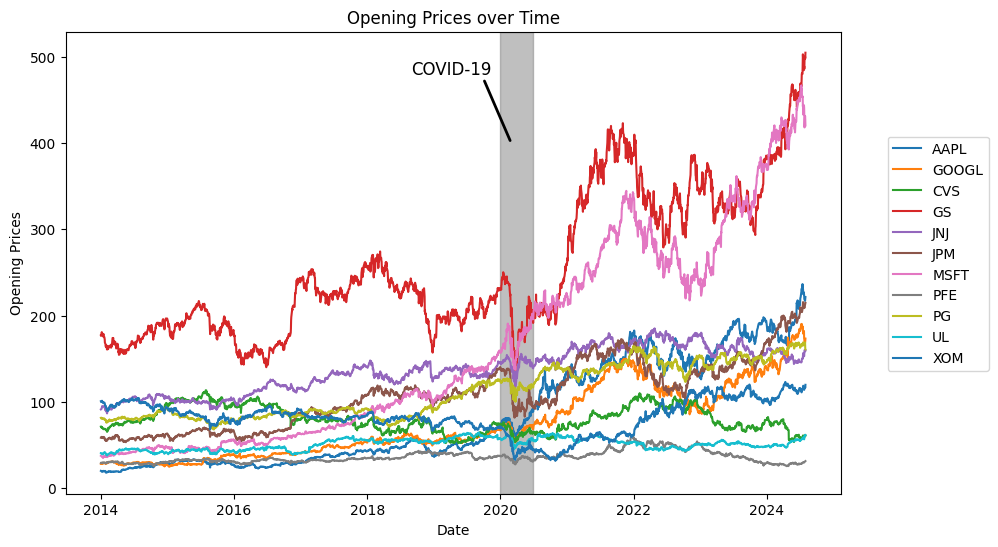

In [226]:
# data_cleaner(combined, 'Close/Last', 'Closing Prices')
# data_cleaner(combined, 'Open', 'Opening Prices')
# data_cleaner(combined, 'High', 'Lowest Prices')
data_cleaner(stock_data, 2014, 'Open', 'Opening Prices')
